# Colossus tutorial: MCMC fitting

Colossus includes a basic MCMC fitting module based on the [Goodman & Weare 2010](http://adsabs.harvard.edu/abs/2010CAMCS...5...65G) algorithm, contributed by Andrey Kravtsov. 

In [1]:
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First, we need to define a likelihood function which we are trying to maximize. For a quick demonstration, let's use a double Gaussian with correlated parameters:

In [2]:
def likelihood(x):

    sig1 = 1.0
    sig2 = 2.0
    r = 0.95
    r2 = r * r
    res = np.exp(-0.5 * ((x[:, 0] / sig1)**2 + (x[:, 1] / sig2)**2 - 2.0 * r * x[:, 0] * x[:, 1] \
            / (sig1 * sig2)) / (1.0 - r2)) / (2 * np.pi * sig1 * sig2) / np.sqrt(1.0 - r2)

    return res

Running the MCMC is easy now: we need to decide on an initial guess for the parameters and a number of "walkers" (chains that run in parallel). 

In [3]:
param_names = ['x1', 'x2']
x_initial = np.array([1.0, 1.0])
n_params = len(param_names)

We could just use the `run()` function to complete all the following steps in one function call, but for the sake of demonstration, let's break it down into the main steps.

First, the `runChain()` function does the actual MCMC sampling. It takes more optional arguments than shown in the code below. By default, the MCMC is stopped when the Gelman-Rubin criterion is below a certain number in all parameters. Running this code should take less than a minute on a modern laptop. 

In [4]:
from colossus.utils import mcmc

walkers = mcmc.initWalkers(x_initial, nwalkers = 200, random_seed = 156)
chain_thin, chain_full, _ = mcmc.runChain(likelihood, walkers)

Running MCMC with the following settings:
Number of parameters:                      2
Number of walkers:                       200
Save conv. indicators every:             100
Finish when Gelman-Rubin less than:   0.0100
-------------------------------------------------------------------------------------
Step    100, autocorr. time  28.7, GR = [  1.318  1.323]
Step    200, autocorr. time  51.1, GR = [  1.131  1.138]
Step    300, autocorr. time  51.7, GR = [  1.086  1.090]
Step    400, autocorr. time  52.7, GR = [  1.063  1.068]
Step    500, autocorr. time  50.8, GR = [  1.049  1.055]
Step    600, autocorr. time  49.5, GR = [  1.040  1.046]
Step    700, autocorr. time  48.6, GR = [  1.035  1.039]
Step    800, autocorr. time  47.3, GR = [  1.033  1.037]
Step    900, autocorr. time  45.9, GR = [  1.029  1.033]
Step   1000, autocorr. time  44.7, GR = [  1.025  1.028]
Step   1100, autocorr. time  42.0, GR = [  1.023  1.026]
Step   1200, autocorr. time  41.7, GR = [  1.021  1.023]
Step   1

Given the chain output, we can now compute the most likely values for the parameters as well as confidence intervals. We use the thinned chain for this purpose because the full chain's individual samples are highly correlated, leading to erroneous statistical inferences.

In [5]:
mcmc.analyzeChain(chain_thin, param_names = param_names);

-------------------------------------------------------------------------------------
Statistics for parameter 0, x1:
Mean:              -5.000e-03
Median:            -1.595e-02
Std. dev.:         +9.745e-01
68.3% interval:    -9.792e-01 .. +9.680e-01
95.5% interval:    -1.925e+00 .. +1.986e+00
99.7% interval:    -2.819e+00 .. +3.151e+00
-------------------------------------------------------------------------------------
Statistics for parameter 1, x2:
Mean:              -1.308e-02
Median:            -1.386e-02
Std. dev.:         +1.952e+00
68.3% interval:    -1.972e+00 .. +1.924e+00
95.5% interval:    -3.925e+00 .. +3.972e+00
99.7% interval:    -5.824e+00 .. +5.848e+00


To elucidate the individual and joint likelihood distributions of the parameters, it is helpful to plot the chain output. The following function does just that:

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

def plotChain(chain, param_labels):

    nsamples = len(chain)
    nparams = len(chain[0])

    # Prepare panels
    margin_lb = 1.0
    margin_rt = 0.5
    panel_size = 2.5
    size = nparams * panel_size + margin_lb + margin_rt
    fig = plt.figure(figsize = (size, size))
    gs = gridspec.GridSpec(nparams, nparams)
    margin_lb_frac = margin_lb / size
    margin_rt_frac = margin_rt / size
    plt.subplots_adjust(left = margin_lb_frac, bottom = margin_lb_frac, right = 1.0 - margin_rt_frac,
                    top = 1.0 - margin_rt_frac, hspace = margin_rt_frac, wspace = margin_rt_frac)
    panels = [[None for dummy in range(nparams)] for dummy in range(nparams)] 
    for i in range(nparams):
        for j in range(nparams):
            if i >= j:
                pan = fig.add_subplot(gs[i, j])
                panels[i][j] = pan
                if i < nparams - 1:
                    pan.set_xticklabels([])
                else:
                    plt.xlabel(param_labels[j])
                if j > 0:
                    pan.set_yticklabels([])
                else:
                    plt.ylabel(param_labels[i])
            else:
                panels[i][j] = None

    # Plot 1D histograms
    nbins = min(50, nsamples / 20.0)
    minmax = np.zeros((nparams, 2), float)
    for i in range(nparams):
        ci = chain[:, i]
        plt.sca(panels[i][i])
        _, bins, _ = plt.hist(ci, bins = nbins)
        minmax[i, 0] = bins[0]
        minmax[i, 1] = bins[-1]
        diff = minmax[i, 1] - minmax[i, 0]
        minmax[i, 0] -= 0.03 * diff
        minmax[i, 1] += 0.03 * diff
        plt.xlim(minmax[i, 0], minmax[i, 1])

    # Plot 2D histograms
    for i in range(nparams):
        ci = chain[:, i]
        for j in range(nparams):
            cj = chain[:, j]
            if i > j:
                plt.sca(panels[i][j])
                plt.hist2d(cj, ci, bins = 100, norm = LogNorm(), density = True)
                plt.ylim(minmax[i, 0], minmax[i, 1])
                plt.xlim(minmax[j, 0], minmax[j, 1])

This function is not part of the main body of Colossus because it relies on matplotlib. Here is its output for the chain above:

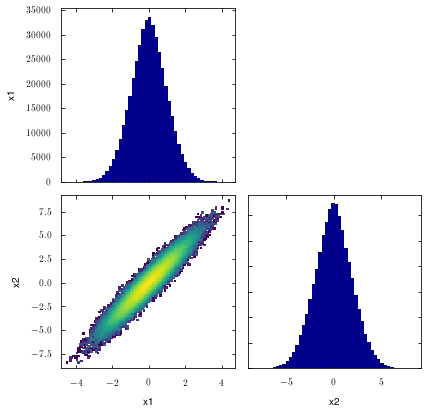

In [7]:
plotChain(chain_full, param_names)
plt.show()